In [1]:
import os,sys,subprocess,glob,cftime,importlib,pickle,itertools
from datetime import datetime
import xarray as xr
import numpy as np
sys.path.append('../')

# current

In [4]:
# load configuration settings
experiment_configuration = importlib.import_module(f"experiment_configuration.p1")

# finalize experiment configuration
from experiment_configuration.experiment import experiment
exp = experiment(experiment_configuration.config)

In [5]:
txt = '''#!/bin/bash

#SBATCH --job-name=launch_resimulate_initial      # Specify job name
#SBATCH --partition=compute     # Specify partition name
#SBATCH --ntasks=1             # Specify max. number of tasks to be invoked
#SBATCH --cpus-per-task=1     # Specify number of CPUs per task
#SBATCH --time=04:00:00        # Set a limit on the total run time
#SBATCH --account=bb1152       # Charge resources on this project account
#SBATCH --output=log/%j    # File name for standard output
#SBATCH --error=log/%j    # File name for standard error output

'''

In [6]:
for i,initial_condition in enumerate(exp.initial_conditions):
    case_identifier = initial_condition.split('.')[-4] + '_' + initial_condition.split('/')[-1].split('-')[0]
    command = f"python /home/u/u290372/projects/REA_with_CESM2/branch_perturbed.py --dkrz_project bb1152 --case_identifier {case_identifier} --case_path GKLT/initial_{exp.initial_conditions_name} --parent_path {initial_condition} --perturbation_seed 0 --compset {exp.compset} --ndays 90 --output gklt_summer"
    if i == 0:
        precompiled_path = f"GKLT/initial_{exp.initial_conditions_name}/{case_identifier}/"
    else:
        command += f" --precompiled_path {precompiled_path}"
    txt += command + ' --overwrite \n'

In [7]:
with open('resimulate_initial.sh', 'w') as fl:
    fl.write(txt)

# check if identical

In [26]:
nc_new = xr.open_dataset('/work/bb1152/u290372/cesm215_archive/GKLT/initial_2024-2026/ens001_2024/atm/hist/ens001_2024.cam.h1.2024-06-01-00000.nc')

In [18]:
nc_orig = xr.open_dataset('/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens001.fE.2020.ens000/atm/hist/b.e215.BSSP370cmip6.f09_g17.001.2005.ens001.fE.2020.ens000.cam.h1.2024-01-02-00000.nc')

In [29]:
nc_orig['TREFHT'].loc['2024-06':'2024-08-29'][:,20,20] == nc_new['TREFHT'].loc['2024-06':'2024-08-29'][:,20,20]

<xarray.DataArray 'TREFHT' (time: 90)> Size: 90B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])
Coordinates:
    lat      float64 8B -71.15
    lon      float64 8B 25.0
  * time     (time) object 720B 2024-06-01 00:00:00 ... 2024-08-29 00:00:00

In [30]:
nc_orig['TREFHT'].loc['2024-06':'2024-08-29'][0] == nc_new['TREFHT'].loc['2024-06':'2024-08-29'][0]

<xarray.DataArray 'TREFHT' (lat: 192, lon: 288)> Size: 55kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time     object 8B 2024-06-01 00:00:00

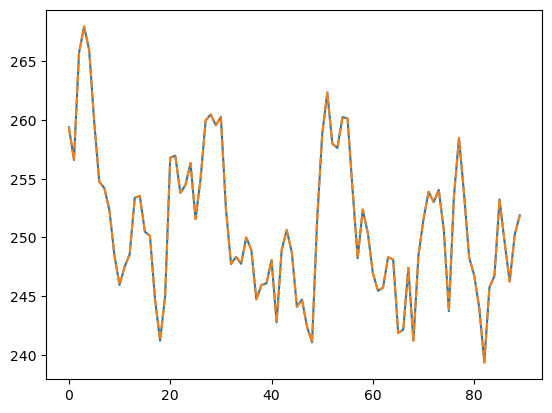

In [32]:
import matplotlib.pyplot as plt
plt.plot(nc_orig['TREFHT'].loc['2024-06':'2024-08-29'][:,20,20])
plt.plot(nc_new['TREFHT'].loc['2024-06':'2024-08-29'][:,20,20],linestyle='--')